In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [40]:
M = np.array([0, 1])
V = np.array([np.NaN, 0.76])
Y = np.array([0, 0])
# Y = M * V
# Y[M == 1] = V[M == 1]
M * np.nan_to_num(V)

array([ nan, 0.76])

In [132]:
class GraphNet:
    # Make an empty graph on n nodes with linear activation
    def __init__(self, n):
        self.size = n
        self.adj = np.zeros((n, n))
        self.weights = np.zeros((n, n))
        self.act = np.asarray(['linear' for i in range(self.size)])
        self.input_nodes = np.asarray([0]) # Default
        self.output_nodes = np.asarray([n-1]) # Default
        self.loss_function = 'SE' # Default squared error -- Other option will be 'CE', cross-entropy
        #self.tempstates = [np.zeros(self.size)] # Needs to be dynamically resized
        #self.states = [np.zeros(self.size)] # Needs to be dynamically resized
        #self.mode = 'overwrite'
        #self.time = 0
    
    # Options are 'SE' and 'CE'
    # 'CE' should only be used for binary outputs
    def set_loss_function(self, lf):
        self.loss_function = lf
    
    # Sets the mode for the step method
    # Options: overwrite, add
    def mode(self, m):
        self.mode = m
    
    # Connect an edge from node i to node j
    def connect(self, i, j):
        self.adj[i,j] = 1
    
    # Connect a list of nodes in a sequential loop
    def connect_loop(self, v):
        for i in range(len(v)):
            self.adj[v[i], v[(i+1)%len(v)]] = 1
    
    # Connect in a clique, other than self-connections
    def connect_complete(self, v):
        for i in range(len(v)):
            for j in range(len(v)):
                if i == j:
                    continue
                self.adj[v[i], v[j]] = 1
    
    # Change activation on node i
    # Options: linear, relu, sigmoid/logistic, tanh
    def activation(self, i, f):
        self.act[i] = f
    
    # Change activations on a list of nodes
    def activations(self, v, f):
        for i in range(len(v)):
            self.act[v[i]] = f
    
    # Get the list of node indices for inputs to node i
    def inputs(self, i):
        return np.nonzero(self.adj[:,i])[0] # Returns a tuple even on a 1D array
    
    # Get the list of node indices for outputs from node i
    def outputs(self, i):
        return np.nonzero(self.adj[i,:])[0] # Returns a tuple even on a 1D array
    
    # Reset weights
    def reset_weights(self):
        self.weights = np.copy(self.adj)
        self.reset_state() # No reason to save the state if the weights were reset.
    
    # Initialize random edge weights, assuming edge weights are all 0 or 1
    def init_random(self):
        self.weights = np.random.normal(size=(self.size, self.size)) * self.adj
    
    # Normalize rows to satisfy Markov state transition rules
    def init_markov(self):
        self.weights = np.random.random((self.size, self.size)) * self.adj
        rowsums = np.sum(self.weights, axis=1, keepdims=True)
        rowsums[rowsums == 0] = 1 # Prevent division by zero when normalizing the columns
        self.weights = self.weights/rowsums
    
    def init_uniform(self):
        self.weights = np.copy(self.adj)
    
    # Make the vector of indices be the input nodes
    def define_input(self, v):
        self.input_nodes = v
    
    # Make the vector of indices be the output nodes
    def define_output(self, v):
        self.output_nodes = v
        
    # numpy activation functions
    # could be static, but meh
    def relu(self, x):
        return x * (x > 0)
    
    def sigmoid(self, x):
        return 1.0/(1.0+np.exp(-x))
    
    def tanh(self, x):
        return (np.exp(2*x) - 1)/(np.exp(2*x) + 1)
    
    # TODO: Redesign the steps so that multiple steps are done and the array of states is optionally returned,
    # so that it doesn't modify the state variable every time it runs the network.
    # This will allow for greater thread concurrency.
    
    # Combine all the old step functions
    # Length of the output is n+1 because of the initial state of 0
    def step(self, input_vals, n, weights = None):
        temp_weights = self.weights
        if weights is not None:
            temp_weights = weights
        x_states = [np.zeros(self.size)]
        z_states = [np.zeros(self.size)]
        input_vals = np.array(input_vals)
        
        for t in range(n):
            input_state = np.zeros(self.size)
            if input_vals.ndim == 1 and t == 0:
                # Single value input
                input_state[self.input_nodes] = input_vals
            elif input_vals.ndim == 2:
                # Sequence input
                if t < input_vals.shape[0]:
                    input_state[self.input_nodes] = input_vals[t]

            # Bias neurons need to be activated before the step
            input_state[self.act == 'bias'] = 1
            
            # This feels like it could be really bad.
            # This makes it *absolutely mandatory* that there are no connections feeding into the input neurons.
            z_states[-1] += input_state

            # Activation functions are not run on the input nodes prior to entering the network.
            # Preprocessing should take care of that anyway.
            # So the inputs are considered the z state for their respective neurons.
            # The x states on those neurons are all zero, but it doesn't really matter, 
            # since they can't come up in the backprop anyway.
            
            # Weighted sum of inputs (always adding the input state in)
            new_x_state = z_states[-1] @ temp_weights
            
            # Apply activation functions to update the state (temporary states are stored for backprop)
            new_z_state = np.copy(new_x_state)

            # Applying activation functions in separate sets for each neuron that has a given one
            new_z_state[self.act == 'relu'] = self.relu(new_z_state[self.act == 'relu'])
            # This is kind of dumb, but initializing with 'linear' means numpy will cut off the string 'sigmoid'
            new_z_state[self.act == 'sigma'] = self.sigmoid(new_z_state[self.act == 'sigma']) 
            new_z_state[self.act == 'tanh'] = self.tanh(new_z_state[self.act == 'tanh'])
            
            x_states.append(new_x_state)
            z_states.append(new_z_state)
        return np.array(x_states), np.array(z_states)
    
    # Simple function to get cleaner output
    def get_output(self, input_vals, n_steps, seq_len=1):
        x, z = self.step(input_vals, n_steps)
        return z[-seq_len:][:, self.output_nodes]
    
    # Combine all the old error functions (for MSE)
    # Error calculation must be separate for backprop, because we don't want to run through the steps multiple times.
    # So this is just for model evaluation (for a particular training example)
    def get_loss(self, input_sequence, label_sequence, delay, weights=None):
        using_weights = False
        temp_weights = None
        if weights is not None:
            using_weights = True
            temp_weights = weights
        seq_len = 1
        steps = delay
        label_sequence = np.array(label_sequence)
        if label_sequence.ndim == 2:
            seq_len = label_sequence.shape[0]
            steps = delay + seq_len - 1
        x_states, z_states = self.step(input_sequence, steps, temp_weights if using_weights else None)
        outputs = z_states[-seq_len:, self.output_nodes]
        if self.loss_function == 'SE':
            # Squared error
            error = np.sum(np.subtract(outputs, label_sequence)**2)
            return 0.5*error # 1/2 sum (z-y)^2
        else:
            # Binary cross-entropy
            crossentropy = -np.sum(label_sequence * np.log(outputs) + (1 - label_sequence) * np.log(1 - outputs))
            return crossentropy
    
    def derivative_relu(self, x):
        return 1 * (x > 0)
    
    # Note that this uses Z instead of X
    def derivative_sigmoid(self, z):
        return z * (1 - z)
    
    def derivative_tanh(self, x):
        return 4/(np.exp(x) + np.exp(-x))**2
    
    def derivative_activation(self, X, Z, t):
        V = np.ones(self.size)
        #V[self.act == 'linear'] = 1
        V[self.act == 'bias'] = 0
        V[self.act == 'relu'] = self.derivative_relu(X[t][self.act == 'relu'])
        V[self.act == 'sigma'] = self.derivative_sigmoid(Z[t][self.act == 'sigma']) 
        V[self.act == 'tanh'] = self.derivative_tanh(X[t][self.act == 'tanh'])
        return V
    
    def backprop(self, input_sequence, label_sequence, delay, debug=False, weights=None):
        # Calculate the required number of steps using the delay and the length of the label sequence
        # If the label sequence is not two-dimensional, then it's just a single output value
        using_weights = False
        if weights is not None:
            using_weights = True
        seq_len = 1
        steps = delay
        label_sequence = np.array(label_sequence)
        if label_sequence.ndim == 2:
            seq_len = label_sequence.shape[0]
            steps = delay + seq_len - 1
        # Outputs at each time step before and after applying activation functions
        X, Z = self.step(input_sequence, steps)
        # Output labels
        Y = np.zeros((seq_len, self.size))
        Y[:, self.output_nodes] = label_sequence
        # X and Z are steps x size
        # Y is seq_len x size
        # Square error
        E = np.sum((Z[-seq_len:, self.output_nodes] - label_sequence)**2)
        # Masking values
        M = np.zeros(self.size)
        M[self.output_nodes] = 1
        # Alias to make things easier to keep track of...
        W = self.weights if not using_weights else weights
        #if debug:
        #    print('W', '\n'+str(W))
        # Going to be dividing by weights, but throw them out entirely if they are zero
        # Turns out the bug was that the values are uninitialized when the where argument is used.
        # Easy enough to fix. I still think it's weird that the result depended on whether the array was printed or not.
        W_recip = np.zeros_like(W)
        np.reciprocal(W, out=W_recip, where=(W != 0))
        if debug:
            print('W recip', '\n'+str(W_recip))
        # Time delay
        T = delay
        # Column of 1s to perform broadcasting before a dot product
        C = np.ones((self.size, 1))
        # The gradient for each weight in the adjacency matrix
        D = np.zeros((self.size, self.size))
        for S in range(0, seq_len):
            # Path concatenation matrix: Weights times activations (applied to X, at various time steps)
            B_final = W * self.derivative_activation(X, Z, T+S)
            if debug:
                print('B at', T+S, '\n'+str(B_final))
            # First order term is relatively simple
            # Output factor needs to only be calculated for places it should be, otherwise it can end up as nan
            output_factor = np.zeros((1, self.size))
            output_factor[:, self.output_nodes] = Z[(T+S):(T+S+1),self.output_nodes] - Y[S:(S+1),self.output_nodes] if self.loss_function == 'SE' else -Y[S:(S+1),self.output_nodes]/Z[(T+S):(T+S+1),self.output_nodes] + (1 - Y[S:(S+1),self.output_nodes])/(1 - Z[(T+S):(T+S+1),self.output_nodes])
            if debug:
                print('output factor','\n'+str(output_factor)) 
            # output_factor now contains M anyway, so the factor of M was taken out of here
            first_order = Z[(T+S-1):(T+S)].T * W_recip * output_factor * B_final
            if debug:
                print('first order', '\n'+str(first_order))
            D += first_order
            B_prod = B_final.copy()
            for N in range(1, T+S):
                # Pre-multiply by the previous time's path concatenation matrix
                B_prev = W * self.derivative_activation(X, Z, T+S-N)
                if debug:
                    print('B at', T+S-N, '\n'+str(B_prev))
                # Calculate the next order, lining up the matrix product to get a sum over outputs
                # Again, factor of M was taken out because output_factor already has it
                next_order = Z[(T+S-N-1):(T+S-N)].T * W_recip * B_prev * ((C @ output_factor) @ B_prod.T)
                if debug:
                    print('next order', '\n'+str(next_order))
                D += next_order
                B_prod = B_prev @ B_prod
                if debug:
                    print('B_prod', '\n'+str(B_prod))
        # This gradient is calculated for one training example over enough time steps to reach time zero
        if debug:
            print('D', '\n'+str(D))
        return D, E
    
    # Example to make sure this makes sense
    # T = 1, seq_len = 1
    # S = 0, B_1 first
    # Z[0:1].T / W * (Z[1:2] - Y[0:1]) * M * B_1
    # N loop doesn't activate
    #
    # T = 2, seq_len = 1
    # S = 0, B_2 first
    # Z[1:2].T / W * (Z[2:3] - Y[0:1]) * M * B_2
    # Z[0:1].T / W * (C @ ((Z[2:3] - Y[0:1]) * M) @ (B_1 @ B2).T)
    
    # Manually check to see if the gradients line up with what the backprop function gives
    def gradient_check(self, input_sequence, label_sequence, delay, epsilon):
        backprop_gradient = self.backprop(input_sequence, label_sequence, delay)[0]
        manual_gradient = np.zeros((self.size, self.size))
        base_err = self.get_loss(input_sequence, label_sequence, delay)
        for i in range(self.size):
            for j in range(self.size):
                if self.weights[i, j] == 0:
                    continue
                dw = np.zeros((self.size, self.size))
                dw[i, j] = epsilon
                grad = (self.get_loss(input_sequence, label_sequence, delay, self.weights + dw) - base_err)/epsilon
                manual_gradient[i, j] = grad
        print('Backprop-calculated gradient:')
        print(backprop_gradient)
        print('Manually-calculated gradient:')
        print(manual_gradient)
        print('Difference:')
        print(backprop_gradient-manual_gradient)
    
    # Uses the whole dataset as the batches
    def train(self, train_x, train_y, delay, epochs, learning_rate, accelerated=False, momentum=0.9):
        errors = []
        prev_delta_weights = np.zeros((self.size, self.size))
        for ep in range(epochs):
            avg_D = np.zeros((self.size, self.size))
            avg_E = 0
            for k in range(len(train_x)):
                temp_weights = None
                if accelerated:
                    temp_weights = self.weights - momentum * prev_delta_weights
                D, E = self.backprop(train_x[k], train_y[k], delay, weights=temp_weights)
                avg_D += D
                avg_E += E
            avg_D /= len(train_x)
            avg_E /= len(train_x)
            #print(avg_D)
            #print(avg_E)
            if accelerated:
                delta_weights = momentum * prev_delta_weights + learning_rate * avg_D
                self.weights += -delta_weights
                prev_delta_weights = delta_weights
            else:
                self.weights += - learning_rate * avg_D
            # Evaluate error to see how we're doing.
            errors.append(avg_E)
        print(self.weights)
        return errors

In [133]:
bintest = GraphNet(2)
bintest.connect(0,1)
bintest.set_loss_function('CE')
bintest.activation(1, 'sigma')
bintest.init_markov()
bintest.weights

array([[0., 1.],
       [0., 0.]])

In [134]:
bintest.get_output([1], 1)

array([[0.73105858]])

In [135]:
bintest.gradient_check([[1]], [[1]], 1, epsilon=0.00001)

Backprop-calculated gradient:
[[ 0.         -0.26894142]
 [ 0.          0.        ]]
Manually-calculated gradient:
[[ 0.         -0.26894044]
 [ 0.          0.        ]]
Difference:
[[ 0.0000000e+00 -9.8305617e-07]
 [ 0.0000000e+00  0.0000000e+00]]


In [120]:
logtest = GraphNet(3)
logtest.connect(0,2)
logtest.connect(1,2)
logtest.activation(2, 'sigma')
logtest.activation(1, 'bias')
logtest.set_loss_function('CE')
logtest.init_random()

In [112]:
class_0 = np.random.normal(loc=0, scale=0.6, size=(1000, 1))
class_1 = np.random.normal(loc=2, scale=1.4, size=(1000, 1))
data = np.concatenate((class_0, class_1))
labels = np.concatenate((np.zeros((1000, 1)), np.ones((1000, 1))))

In [121]:
# At least a little faster than the version without accelerated gradient descent, but still slow computationally
logtest.train(data, labels, delay=1, epochs=20, learning_rate=0.5, accelerated=True)

[[ 0.         0.         3.2956112]
 [-0.         0.        -2.3610941]
 [-0.         0.        -0.       ]]


[0.282552521295103,
 0.2637960409312155,
 0.23030393521088524,
 0.19047245181430902,
 0.1563106977139622,
 0.13579271770316814,
 0.1271986341902479,
 0.12395111975840686,
 0.12160129948930759,
 0.11903965736576233,
 0.11662702226477746,
 0.11483368947572505,
 0.11385367657729771,
 0.11363741643054119,
 0.11400380434249513,
 0.1147300142706393,
 0.11560500016787828,
 0.11645504985028081,
 0.11715247748625915,
 0.11761568347330544]

In [3]:
test = GraphNet(3)
test.connect(0,1)
test.connect(1,2)
test.activations([1,2], 'sigma')
test.init_markov()
test.weights

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

In [4]:
test.weights *= 0.9

In [5]:
x, z = test.step([1], 2)

In [6]:
print(x)
print(z)

[[0.         0.         0.        ]
 [0.         0.9        0.        ]
 [0.         0.         0.63985455]]
[[1.         0.         0.        ]
 [0.         0.7109495  0.5       ]
 [0.         0.5        0.65472058]]


In [7]:
test.backprop([[1]], [[1]], 2)

(array([[ 0.        , -0.01443618,  0.        ],
        [ 0.        ,  0.        , -0.05549274],
        [ 0.        ,  0.        ,  0.        ]]), 0.11921787702676306)

In [8]:
test.gradient_check([[1]], [[1]], 2, epsilon=0.000001)

Backprop-calculated gradient:
[[ 0.         -0.01443618  0.        ]
 [ 0.          0.         -0.05549274]
 [ 0.          0.          0.        ]]
Manually-calculated gradient:
[[ 0.         -0.01443618  0.        ]
 [ 0.          0.         -0.05549272]
 [ 0.          0.          0.        ]]
Difference:
[[ 0.00000000e+00 -4.35924800e-09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.90231157e-08]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [9]:
linear = GraphNet(3)
linear.connect(0,2)
linear.connect(1,2)
linear.activation(1, 'bias')
linear.define_input([0])
linear.define_output([2])
linear.init_markov() # Makes it really be slope and intercept 1 to begin

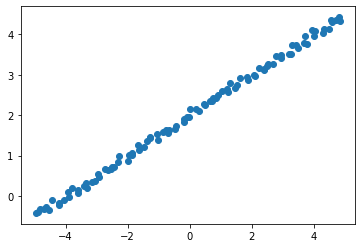

In [10]:
scatter = 0.1
slope = 0.5
intercept = 2
# Uniformly scattered points off a line
train_lin_x = [[-5 + 0.1*i + scatter*(-1+2*random.random())] for i in range(100)]
train_lin_y = [[intercept + slope*(-5+0.1*i) + scatter*(-1+2*random.random())] for i in range(100)]
plt.scatter(train_lin_x, train_lin_y)

In [11]:
linear.get_output([0], 1)

array([[1.]])

In [12]:
# Estimated slope and intercept are present in the weights of the trained network
errs = linear.train(train_lin_x, train_lin_y, delay=1, epochs=100, learning_rate=0.1)

[[0.         0.         0.5001095 ]
 [0.         0.         1.98903566]
 [0.         0.         0.        ]]


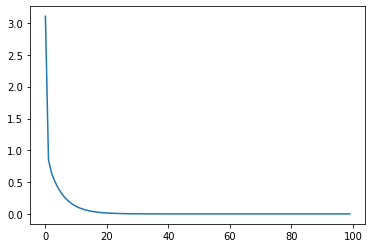

In [13]:
# Seems to work decently well
plt.plot(errs)

In [14]:
linear.gradient_check(train_lin_x[0], train_lin_y[0], delay=1, epsilon=0.000001)

Backprop-calculated gradient:
[[ 0.          0.          0.271837  ]
 [ 0.          0.         -0.05490077]
 [ 0.          0.          0.        ]]
Manually-calculated gradient:
[[ 0.          0.          0.27184926]
 [ 0.          0.         -0.05490027]
 [ 0.          0.          0.        ]]
Difference:
[[ 0.00000000e+00  0.00000000e+00 -1.22583089e-05]
 [ 0.00000000e+00  0.00000000e+00 -5.00004597e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [145]:
# Testing a regular NN as a graph
xor_net = GraphNet(6)
xor_net.define_input([0,1])
xor_net.connect(0,3)
xor_net.connect(0,4)
xor_net.connect(1,3)
xor_net.connect(1,4)
xor_net.connect(2,3)
xor_net.connect(2,4)
xor_net.connect(2,5)
xor_net.connect(3,5)
xor_net.connect(4,5)
xor_net.activation(2, 'bias')
xor_net.activations([3,4,5], 'sigma')
xor_net.init_random()

In [16]:
train_x = [[0,0], [0,1], [1,0], [1,1]]
train_y = [[0], [1], [1], [0]]
errs_xor = xor_net.train(train_x, train_y, delay=2, epochs=5000, learning_rate=0.5)

[[ 0.          0.         -0.          5.06013291 -3.86322932  0.        ]
 [-0.         -0.         -0.         -5.16692561  3.59482771 -0.        ]
 [-0.         -0.         -0.         -3.14425786 -1.98745604 -2.68042021]
 [-0.          0.          0.          0.         -0.          5.51608361]
 [-0.          0.          0.         -0.         -0.          5.42085205]
 [-0.         -0.          0.          0.          0.          0.        ]]


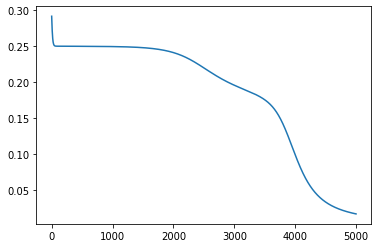

In [17]:
plt.plot(errs_xor)

[[ 0.          0.         -0.         -6.16814857  4.84210956  0.        ]
 [-0.          0.         -0.          6.19967277 -5.12386351 -0.        ]
 [ 0.          0.          0.         -3.54654842 -2.70140589 -3.73907307]
 [ 0.         -0.         -0.         -0.         -0.          7.45318735]
 [-0.          0.         -0.         -0.         -0.          7.71306033]
 [-0.          0.         -0.         -0.         -0.         -0.        ]]


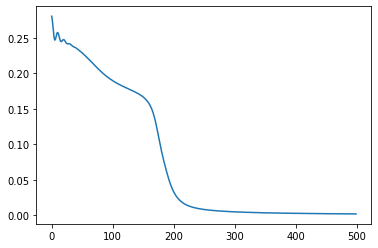

In [146]:
# Since this takes like 5000 epochs, I wanted to try it with accelerated gradient descent to compare
train_x = [[0,0], [0,1], [1,0], [1,1]]
train_y = [[0], [1], [1], [0]]
errs_xor = xor_net.train(train_x, train_y, delay=2, epochs=500, learning_rate=1, accelerated=True)
plt.plot(errs_xor)
# It trains in 1/10 the number of epochs, so great!

In [147]:
print(xor_net.get_output([0,0], 2))
print(xor_net.get_output([0,1], 2))
print(xor_net.get_output([1,0], 2))
print(xor_net.get_output([1,1], 2))

[[0.04542586]]
[[0.96183042]]
[[0.95941788]]
[[0.04101035]]


In [19]:
xor_net.gradient_check(train_x, train_y, delay=2, epsilon=0.000001)

Backprop-calculated gradient:
[[ 0.          0.          0.         -0.00343948  0.0060595   0.        ]
 [ 0.          0.          0.          0.00262133 -0.00607109  0.        ]
 [ 0.          0.          0.          0.00031637  0.00371128  0.00448841]
 [ 0.          0.          0.          0.          0.         -0.00738545]
 [ 0.          0.          0.          0.          0.         -0.01025068]
 [ 0.          0.          0.          0.          0.          0.        ]]
Manually-calculated gradient:
[[ 0.          0.          0.         -0.00343948  0.00605951  0.        ]
 [ 0.          0.          0.          0.00262133 -0.00607107  0.        ]
 [ 0.          0.          0.          0.00031638  0.0037113   0.00448846]
 [ 0.          0.          0.          0.          0.         -0.00738545]
 [ 0.          0.          0.          0.          0.         -0.01025067]
 [ 0.          0.          0.          0.          0.          0.        ]]
Difference:
[[ 0.00000000e+00  0.00000

In [20]:
bpcheck = GraphNet(8)
bpcheck.define_input([0,1])
bpcheck.define_output([6,7])
bpcheck.connect(0,2)
bpcheck.connect(1,2)
bpcheck.connect_loop([2,3,4,5])
bpcheck.connect(4,6)
bpcheck.connect(4,7)
#bpcheck.init_random()
bpcheck.init_uniform()
# Square loop with two inputs and outputs

In [21]:
# Make sure regular stepping works
#print(bpcheck.step([0,1]))
#print(bpcheck.step([0,0]))
#print(bpcheck.step([0,0]))
#print(bpcheck.step([0,0]))
# Make sure multiple stepping works
#bpcheck.reset_state()
print(bpcheck.get_output([0,1], 12, 5))
print(bpcheck.get_output([1,0], 12, 5))
# These are the same, as expected. Bug fixed.

[[1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]]
[[1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]]


In [22]:
train_x = [[[0,1]]]
train_y = [[[1,1], [0,0], [0,0], [0,0], [0.5,0.5]]]
errs_bpc = bpcheck.train(train_x, train_y, delay=4, epochs=200, learning_rate=0.05)

[[0.         0.         1.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.11742165 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.91886753 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.91886753 0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.76954337
  1.0599282  1.0599282 ]
 [0.         0.         0.76954337 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]


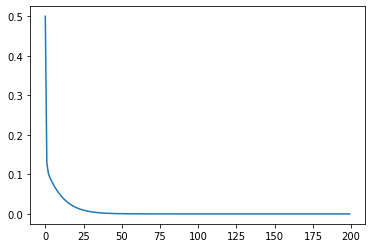

In [23]:
plt.plot(errs_bpc)

In [24]:
# Trained perfectly
bpcheck.get_output([0,1], 12, 5)

array([[0.50000155, 0.50000155],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.25000193, 0.25000193]])

In [25]:
fc = GraphNet(7)
fc.connect(0,1)
fc.connect_complete([1,2,3,4,5])
fc.connect(5,6)
#fc.activation(6, 'sigma')
fc.init_markov()

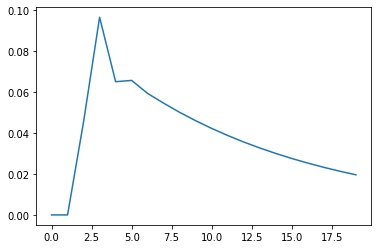

In [26]:
plt.plot(fc.get_output([1], 20, 20))

In [27]:
fc.backprop([[1]], [[1]], delay=10)

(array([[ 0.        , -0.04393084,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.09128415, -0.09127294, -0.09122264,
         -0.09219175,  0.        ],
        [ 0.        , -0.05071242,  0.        , -0.05351786, -0.05291075,
         -0.06516243,  0.        ],
        [ 0.        , -0.06939477, -0.07258681,  0.        , -0.0717497 ,
         -0.08580668,  0.        ],
        [ 0.        , -0.07501129, -0.07868004, -0.0782708 ,  0.        ,
         -0.09337181,  0.        ],
        [ 0.        , -0.06726503, -0.07135794, -0.0711031 , -0.07034976,
          0.        , -0.12378711],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ]]), 0.9100175704677823)

In [28]:
fc.gradient_check([[1]], [[1]], delay=10, epsilon=0.00001)

Backprop-calculated gradient:
[[ 0.         -0.04393084  0.          0.          0.          0.
   0.        ]
 [ 0.          0.         -0.09128415 -0.09127294 -0.09122264 -0.09219175
   0.        ]
 [ 0.         -0.05071242  0.         -0.05351786 -0.05291075 -0.06516243
   0.        ]
 [ 0.         -0.06939477 -0.07258681  0.         -0.0717497  -0.08580668
   0.        ]
 [ 0.         -0.07501129 -0.07868004 -0.0782708   0.         -0.09337181
   0.        ]
 [ 0.         -0.06726503 -0.07135794 -0.0711031  -0.07034976  0.
  -0.12378711]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]]
Manually-calculated gradient:
[[ 0.         -0.04393083  0.          0.          0.          0.
   0.        ]
 [ 0.          0.         -0.09128469 -0.09127351 -0.09122317 -0.09219242
   0.        ]
 [ 0.         -0.05071256  0.         -0.05351803 -0.05291097 -0.06516267
   0.        ]
 [ 0.         -0.06939511 -0.07258719  0.         -0.07175003 -0.08580714
   0.  